In [40]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers

import pandas as pd
from pandas import read_csv

In [41]:
# Convert from 64 to 32 bit floats
X_test = np.load("/home/alon/school/c247a/datasets/project_data/project/X_test.npy").astype(np.float32)
y_test = np.load("/home/alon/school/c247a/datasets/project_data/project/y_test.npy").astype(np.float32)
person_train_valid = np.load("/home/alon/school/c247a/datasets/project_data/project/person_train_valid.npy").astype(np.float32)
X_train_valid = np.load("/home/alon/school/c247a/datasets/project_data/project/X_train_valid.npy").astype(np.float32)
y_train_valid = np.load("/home/alon/school/c247a/datasets/project_data/project/y_train_valid.npy").astype(np.float32)
person_test = np.load("/home/alon/school/c247a/datasets/project_data/project/person_test.npy").astype(np.float32)

# adjust labels 
y_train_valid -= 769
y_test -= 769

print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))
print('y_train_valid', y_train_valid[:10])

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)
y_train_valid [2. 3. 0. 0. 0. 0. 2. 1. 3. 3.]


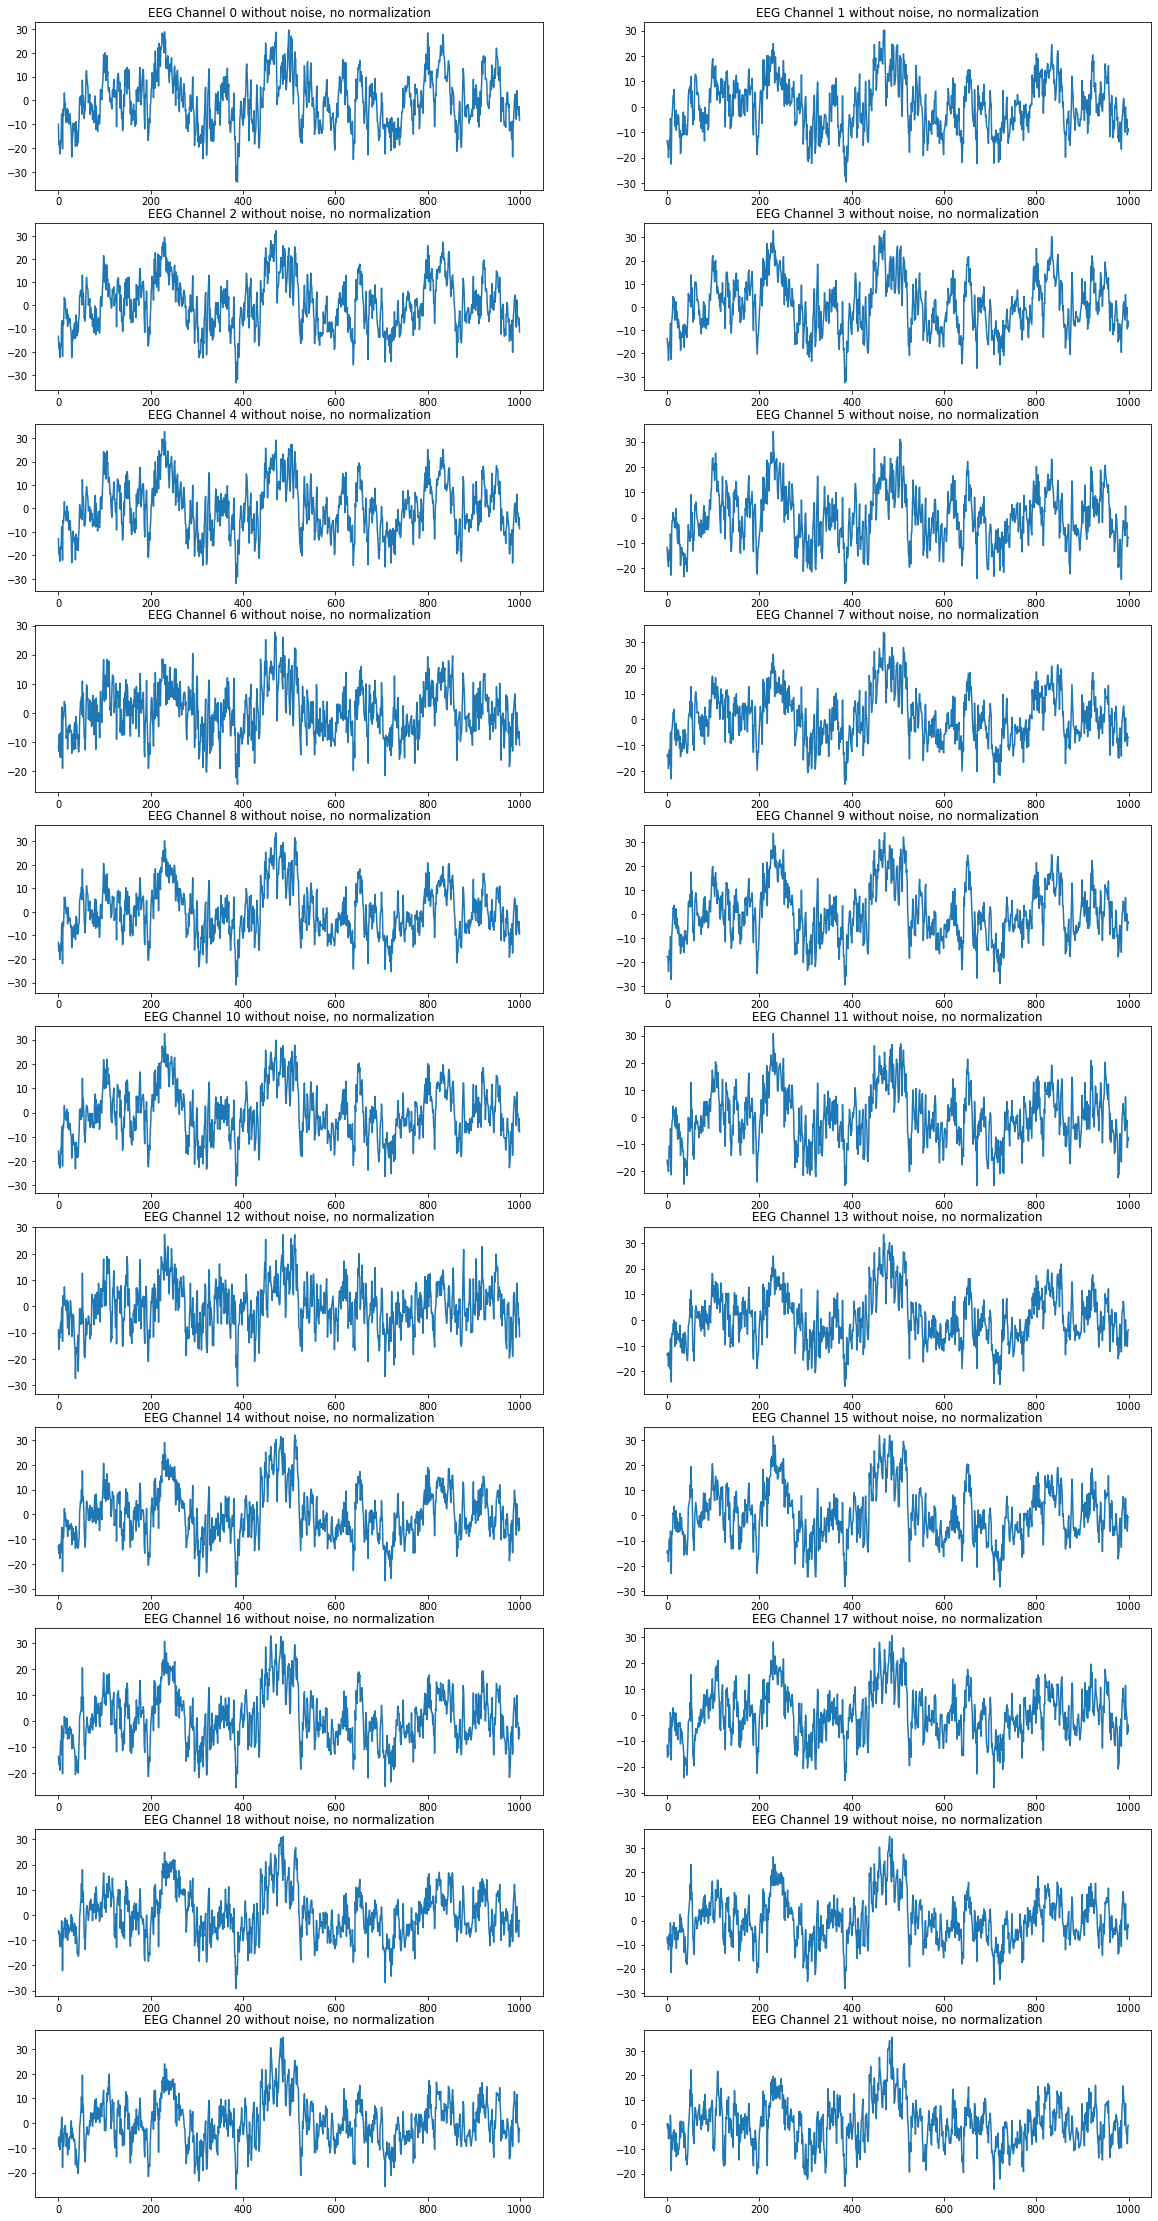

In [3]:
#take a look at a random capture

fig, axs = plt.subplots(11,2,figsize=(20,40))

count = 0

eeg_ix = 10

for i in range(22):
    axs[int(i/2),count].plot(X_train_valid[eeg_ix,i,:])
    axs[int(i/2),count].set_title('EEG Channel {} without noise, no normalization'.format(i))
    
    count += 1
    if (count>1):
        count=0

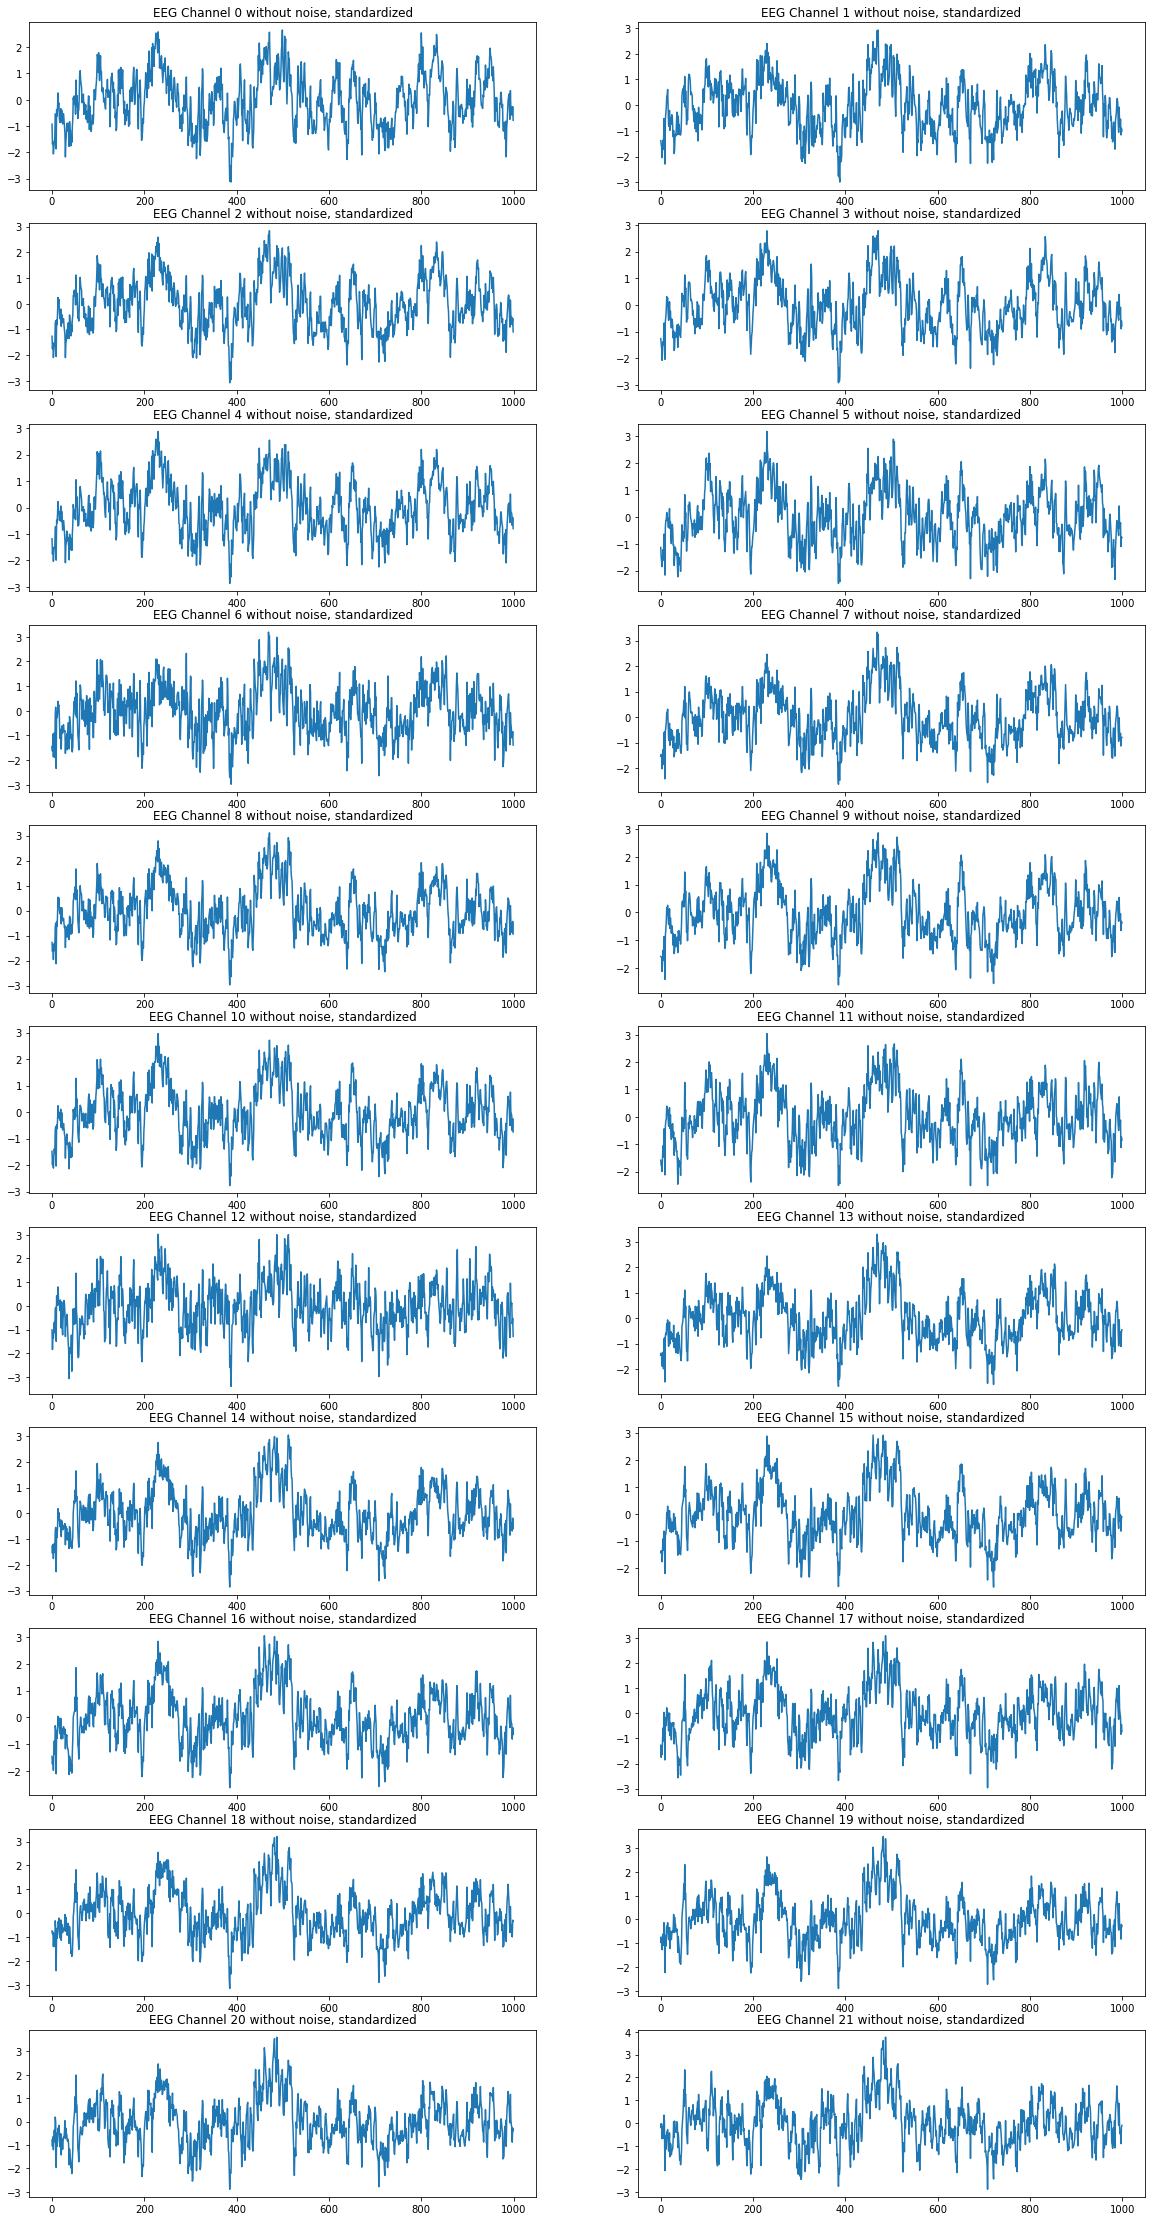

In [4]:
#normalizing each channel of a single run

fig, axs = plt.subplots(11,2,figsize=(20,40))

count = 0

eeg_ix = 10

for i in range(22):
    y = X_train_valid[eeg_ix,i,:]
    mean = np.mean(y)
    std = np.std(y)
    z = (y-mean)/std
    
    axs[int(i/2),count].plot(z)
    axs[int(i/2),count].set_title('EEG Channel {} without noise, standardized'.format(i))
    
    count += 1
    if (count>1):
        count=0
    #print(np.mean(X_train_valid[eeg_ix,i,:]))
    #print(np.std(X_train_valid[eeg_ix,i,:]))

In [42]:
#normalizing and then adding noise to every single training input

X_train_valid_norm = np.zeros_like(X_train_valid)

for eeg_ix in range(X_train_valid.shape[0]):
    for i in range(22):
        #normalize the data
        y = X_train_valid[eeg_ix,i,:]
        mean = np.mean(y)
        std = np.std(y)
        z = (y-mean)/std
        X_train_valid_norm[eeg_ix,i,:] = z
        
mu, sigma = 0, 0.10
s = np.random.normal(mu, sigma, X_train_valid_norm.shape)
print("Noise shape: {}".format(s.shape))
X_train_valid_norm_noised = X_train_valid_norm + s

Noise shape: (2115, 22, 1000)


In [43]:
#normalizing and then adding noise to every single test input

X_test_norm = np.zeros_like(X_test)

for eeg_ix in range(X_test.shape[0]):
    for i in range(22):
        #normalize the data
        y = X_test[eeg_ix,i,:]
        mean = np.mean(y)
        std = np.std(y)
        z = (y-mean)/std
        X_test_norm[eeg_ix,i,:] = z
        
mu, sigma = 0, 0.10
s = np.random.normal(mu, sigma, X_test_norm.shape)
print("Noise shape: {}".format(s.shape))
X_test_norm_noised = X_test_norm + s

Noise shape: (443, 22, 1000)


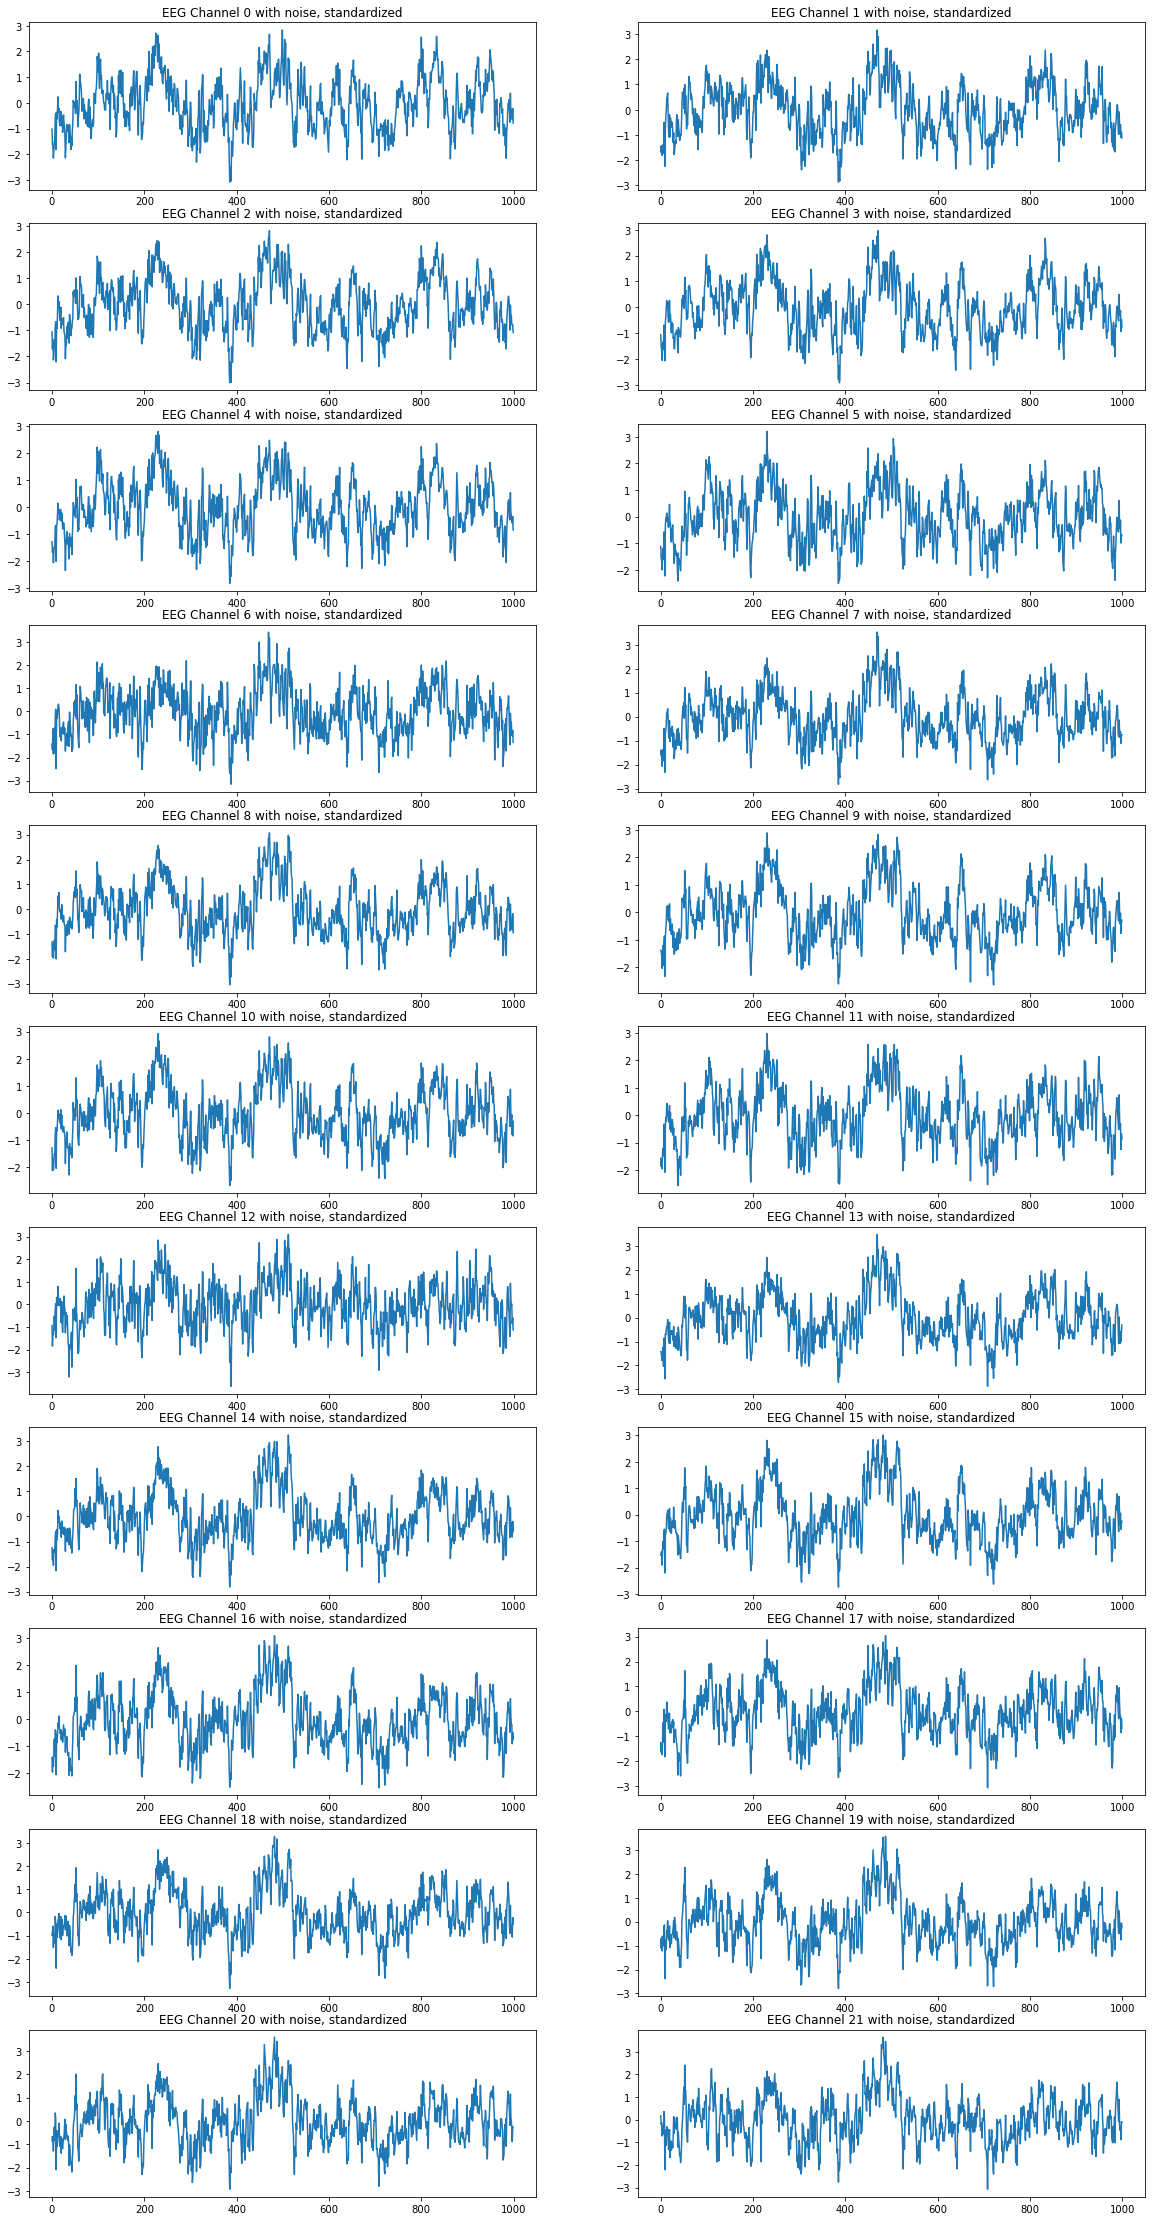

In [7]:
#double check that noise has been added

fig, axs = plt.subplots(11,2,figsize=(20,40))

count = 0

eeg_ix = 10

#X_train_valid_norm = np.zeros_like(X_train_valid)

for i in range(22):
    #normalize the data
    #y = X_train_valid[eeg_ix,i,:]
    #mean = np.mean(y)
    #std = np.std(y)
    #z = (y-mean)/std
    #X_train_valid_norm[eeg_ix,i,:] = z
    
    #generate white gaussian noise and add to the data
    #mu, sigma = 0, 0.1 # mean and standard deviation
    #s = np.random.normal(mu, sigma, 1000)
    
    #z_noised = z + s
    
    axs[int(i/2),count].plot(X_train_valid_norm_noised[eeg_ix,i,:])
    axs[int(i/2),count].set_title('EEG Channel {} with noise, standardized'.format(i))
    
    count += 1
    if (count>1):
        count=0

In [44]:
def convert_to_one_hot(in_arr):
    in_arr = in_arr.reshape((in_arr.shape[0],))
    in_arr = in_arr.astype(int)
    in_arr_1h = np.zeros((in_arr.size, in_arr.max()+1))
    in_arr_1h[np.arange(in_arr.size),in_arr] = 1
    return in_arr_1h

In [45]:
#convert all vectors to one-hot
y_train_valid_1h = convert_to_one_hot(y_train_valid)
y_test_1h = convert_to_one_hot(y_test)

person_train_valid_1h = convert_to_one_hot(person_train_valid)
person_test_1h = convert_to_one_hot(person_test)

In [10]:
#instantiate and initialize pandas dataframes

columns = ['subject_ix', 'subject_one_hot', 'data_22ch', 'event_class_ix', 'event_class_one_hot']

train_val_df = pd.DataFrame(columns=columns)
train_val_df['subject_ix'] = person_train_valid.reshape((person_train_valid.shape[0],))
train_val_df['subject_one_hot'] = person_train_valid_1h.tolist()
train_val_df['event_class_ix'] = y_train_valid
train_val_df['event_class_one_hot'] = y_train_valid_1h.tolist()
#train_val_df['data_22ch'] = X_train_valid.tolist()
train_val_df['data_22ch_std'] = X_train_valid_norm.tolist()
#train_val_df['data_22ch_std_noise'] = X_train_valid_norm_noised.tolist()

test_df = pd.DataFrame(columns=columns)
test_df['subject_ix'] = person_test.reshape((person_test.shape[0],))
test_df['subject_one_hot'] = person_test_1h.tolist()
test_df['event_class_ix'] = y_test
test_df['event_class_one_hot'] = y_test.tolist()
#test_df['data_22ch'] = X_test.tolist()
test_df['data_22ch_std'] = X_test_norm.tolist()
#test_df['data_22ch_std_noise'] = X_test_norm_noised.tolist()

In [11]:
train_val_df

,subject_ix,subject_one_hot,data_22ch,event_class_ix,event_class_one_hot,data_22ch_std
0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",NaN,2.0,"[0.0, 0.0, 1.0, 0.0]","[[0.5015121102333069, 0.16189952194690704, -0...."
1,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",NaN,3.0,"[0.0, 0.0, 0.0, 1.0]","[[0.7360790371894836, 1.2964133024215698, 1.45..."
2,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",NaN,0.0,"[1.0, 0.0, 0.0, 0.0]","[[-1.1618340015411377, -0.9891378283500671, -0..."
3,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",NaN,0.0,"[1.0, 0.0, 0.0, 0.0]","[[0.6685264110565186, 0.520396888256073, 0.286..."
4,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",NaN,0.0,"[1.0, 0.0, 0.0, 0.0]","[[0.3515171706676483, 0.5005025863647461, 1.58..."
...,...,...,...,...,...,...
2110,8.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",NaN,2.0,"[0.0, 0.0, 1.0, 0.0]","[[-2.7849910259246826, -2.6298301219940186, -2..."
2111,8.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",NaN,2.0,"[0.0, 0.0, 1.0, 0.0]","[[-0.9315462708473206, -0.8773410320281982, 0...."
2112,8.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",NaN,3.0,"[0.0, 0.0, 0.0, 1.0]","[[0.5814683437347412, 0.1501563936471939, 0.10..."
2113,8.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",NaN,3.0,"[0.0, 0.0, 0.0, 1.0]","[[-0.8012254238128662, -0.4878029227256775, 0...."


In [ ]:
#examples of obtaining train_val and test dataframes from the larger dataframes

s0_train_val_df = train_val_df[train_val_df['subject_ix'] == 0]
s0_test_df = test_df[test_df['subject_ix'] == 0]

s1_train_val_df = train_val_df[train_val_df['subject_ix'] == 1]
s1_test_df = test_df[test_df['subject_ix'] == 1]

s2_train_val_df = train_val_df[train_val_df['subject_ix'] == 2]
s2_test_df = test_df[test_df['subject_ix'] == 2]

s3_train_val_df = train_val_df[train_val_df['subject_ix'] == 3]
s3_test_df = test_df[test_df['subject_ix'] == 3]

s4_train_val_df = train_val_df[train_val_df['subject_ix'] == 4]
s4_test_df = test_df[test_df['subject_ix'] == 4]

s5_train_val_df = train_val_df[train_val_df['subject_ix'] == 5]
s5_test_df = test_df[test_df['subject_ix'] == 5]

s6_train_val_df = train_val_df[train_val_df['subject_ix'] == 6]
s6_test_df = test_df[test_df['subject_ix'] == 6]

s7_train_val_df = train_val_df[train_val_df['subject_ix'] == 7]
s7_test_df = test_df[test_df['subject_ix'] == 7]

s8_train_val_df = train_val_df[train_val_df['subject_ix'] == 8]
s8_test_df = test_df[test_df['subject_ix'] == 8]

In [ ]:
#example of grabbing the data from a given subject df
s0_X_train_val = np.array([[[value for value in ch] for ch in run] for run in s0_train_val_df['data_22ch'].values], ndmin=3)
#s0_X_train_val = np.array(s0_train_val_df['data_22ch'].values)
s0_y_train_val = s0_train_val_df['subject_ix'].values

In [12]:
def get_X_train_val(df):
    return np.array([[[value for value in ch] for ch in run] for run in df['data_22ch'].values], ndmin=3)

In [13]:
s2_X_train_val = get_X_train_val(s2_train_val_df)
print(s2_X_train_val.shape)

NameError: name 's2_train_val_df' is not defined

In [14]:
def ksquare(x):
  return tf.pow(x, 2)

def klog(x):
  return tf.math.log(x)

In [46]:
# Input layer is used to instantiate a tensor
# Dimensions are (E,T) -> (22, 1000)
input_ = layers.Input(shape=(22, 1000))

# Reshape layer reshapes input into given shape
# output shape is (batch_size,) + target_shape
r1 = layers.Reshape(target_shape=(22, 1000, 1))(input_)

# Temporal convolution layer
# kernel_size is (H,W)
# for channels_last input is a 4D-tensor with dims batch_size + (rows, cols, )
c1 = layers.Conv2D(filters=40, kernel_size=(1,50), data_format='channels_last',
                   activation='elu')(r1)

# Permute layer
p1 = layers.Permute(dims=(2,1,3))(c1)

# Reshape layer
#r2 = layers.Reshape((976, 22*40))(p1)
r2 = layers.Reshape((951, 22*40))(p1)

#Dropout
#dr1 = layers.Dropout(0.8)(r2)

# FC layer
d1 = layers.Dense(40, activation='elu')(r2)
#d1 = layers.Dense(40, activation='elu')(dr1)

#Dropout
dr1 = layers.Dropout(0.8)(d1)


# Activation layer using ksquare
#sq1 = layers.Activation(ksquare)(d1)
sq1 = layers.Activation(ksquare)(dr1)

# Mean pooling layer
ap1 = layers.AveragePooling1D(75, strides=15)(sq1)

# Log activation layer
log1 = layers.Activation(klog)(ap1)

# Flatten layer
f1 = layers.Flatten()(log1)

# Output layer
output_ = layers.Dense(4, activation='softmax')(f1)

In [47]:
model = models.Model(inputs=input_, outputs=output_, name='shallow_convnet')
model.compile('adam', 'categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "shallow_convnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 22, 1000)]        0         
_________________________________________________________________
reshape_14 (Reshape)         (None, 22, 1000, 1)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 22, 951, 40)       2040      
_________________________________________________________________
permute_7 (Permute)          (None, 951, 22, 40)       0         
_________________________________________________________________
reshape_15 (Reshape)         (None, 951, 880)          0         
_________________________________________________________________
dense_13 (Dense)             (None, 951, 40)           35240     
_________________________________________________________________
dropout_2 (Dropout)          (None, 951, 40)       

In [48]:
# X_train_val = get_X_train_val(s2_train_val_df)
# print(s2_X_train_val.shape)
#train_val_df['event_class_one_hot'].values
print(y_train_valid_1h.shape)
print(type(y_train_valid_1h))
print(y_train_valid_1h[1:10])

(2115, 4)
<class 'numpy.ndarray'>
[[0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


Epoch 1/50
53/53 [==============================] - 15s 291ms/step - loss: 1.6893 - acc: 0.2784 - val_loss: 1.5157 - val_acc: 0.3310
Epoch 2/50
53/53 [==============================] - 22s 420ms/step - loss: 1.3688 - acc: 0.3942 - val_loss: 1.4667 - val_acc: 0.3522
Epoch 3/50
53/53 [==============================] - 20s 380ms/step - loss: 1.2827 - acc: 0.4255 - val_loss: 1.5157 - val_acc: 0.3286
Epoch 4/50
53/53 [==============================] - 21s 388ms/step - loss: 1.1962 - acc: 0.4829 - val_loss: 2.0855 - val_acc: 0.2719
Epoch 5/50
53/53 [==============================] - 21s 390ms/step - loss: nan - acc: 0.2866 - val_loss: nan - val_acc: 0.2530
Epoch 6/50
53/53 [==============================] - 21s 402ms/step - loss: nan - acc: 0.2494 - val_loss: nan - val_acc: 0.2530
Epoch 7/50
53/53 [==============================] - 20s 380ms/step - loss: nan - acc: 0.2494 - val_loss: nan - val_acc: 0.2530
Epoch 8/50
53/53 [==============================] - 20s 378ms/step - loss: nan - acc: 0

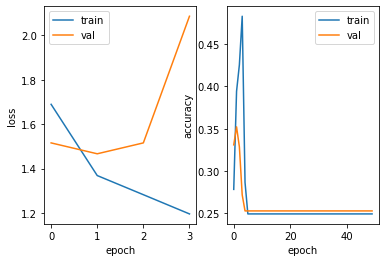

In [49]:
loss_hist = model.fit(X_train_valid_norm, y_train_valid_1h, 
                      validation_split=0.2, epochs=50,
                      verbose=True)

hist = loss_hist.history

plt.subplot(1,2,1)
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

plt.subplot(1,2,2)
plt.plot(hist['acc'])
plt.plot(hist['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

In [ ]:
#normalizing each channel of each run and adding noise

fig, axs = plt.subplots(11,2,figsize=(20,40))

count = 0

eeg_ix = 10

#X_train_valid_norm = np.zeros_like(X_train_valid)

for i in range(22):
    #normalize the data
    y = X_train_valid[eeg_ix,i,:]
    mean = np.mean(y)
    std = np.std(y)
    z = (y-mean)/std
    #X_train_valid_norm[eeg_ix,i,:] = z
    
    #generate white gaussian noise and add to the data
    #mu, sigma = 0, 0.1 # mean and standard deviation
    #s = np.random.normal(mu, sigma, 1000)
    
    #z_noised = z + s
    
    axs[int(i/2),count].plot(z_noised)
    axs[int(i/2),count].set_title('EEG Channel {} with noise, standardized'.format(i))
    
    count += 1
    if (count>1):
        count=0

        
mu, sigma = 0, 0.1
s = np.random.normal(mu, sigma, X_train_valid_norm.shape)




In [ ]:
#normalizing each channel of each run and adding noise

# fig, axs = plt.subplots(11,2,figsize=(20,40))

# count = 0

# eeg_ix = 10

X_train_valid_norm = np.zeros_like(X_train_valid)

for eeg_ix in range(X_train_valid.shape[0]):
    for i in range(22):
        #normalize the data
        y = X_train_valid[eeg_ix,i,:]
        mean = np.mean(y)
        std = np.std(y)
        z = (y-mean)/std
        X_train_valid_norm[eeg_ix,i,:] = z
    
    #generate white gaussian noise and add to the data
    #mu, sigma = 0, 0.1 # mean and standard deviation
    #s = np.random.normal(mu, sigma, 1000)
    
    #z_noised = z + s
    
    #axs[int(i/2),count].plot(z_noised)
    #axs[int(i/2),count].set_title('EEG Channel {} with noise, standardized'.format(i))
    
    #count += 1
    #if (count>1):
    #    count=0

        
mu, sigma = 0, 0.10
s = np.random.normal(mu, sigma, X_train_valid_norm.shape)
print("Noise shape: {}".format(s.shape))
X_train_valid_norm_noised = X_train_valid_norm + s

In [ ]:
fig, axs = plt.subplots(11,2,figsize=(20,40))

count = 0

eeg_ix = 10

#X_train_valid_norm = np.zeros_like(X_train_valid)

for i in range(22):
    #normalize the data
    #y = X_train_valid[eeg_ix,i,:]
    #mean = np.mean(y)
    #std = np.std(y)
    #z = (y-mean)/std
    #X_train_valid_norm[eeg_ix,i,:] = z
    
    #generate white gaussian noise and add to the data
    #mu, sigma = 0, 0.1 # mean and standard deviation
    #s = np.random.normal(mu, sigma, 1000)
    
    #z_noised = z + s
    
    axs[int(i/2),count].plot(X_train_valid_norm_noised[eeg_ix,i,:])
    axs[int(i/2),count].set_title('EEG Channel {} with noise, standardized'.format(i))
    
    count += 1
    if (count>1):
        count=0

In [ ]:
#our model is overfitting - there aren't enough examples
#now let's try adding noise to the data in order to generate more examples



In [ ]:
#try to do a split in time to get every other sample, so instead of 236x22x1000 we have 472x22x500 or even every 4 samples
ixs_even = np.arange(0, s2_X_train_val.shape[0] + 1, 2)
ixs_odd = np.arange(1, s2_X_train_val.shape[0] + 1, 2)